In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import copy

In [2]:
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
gaps_df = gaps_df[gaps_df.type=='N']

In [3]:
sizes_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38_chromsome_sizes.txt', header=None)
sizes_df[0] = [int(i.replace('X', '23').replace('Y', '24').replace('mtDNA', '25')) for i in sizes_df[0]]
sizes_df = sizes_df.sort_values(0)
sizes = [int(s.replace(',','')) for s in sizes_df[2]]
starts_chrom = [np.sum(sizes[:i]) for i in range(24)]

def loci_linear_idx(chrom, loci):
    chrom=int(chrom)
    return starts_chrom[chrom-1]+loci


In [4]:
f, ax = plt.subplots(figsize=(20,.5))
for i in range(23):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    plt.text(x=np.mean(starts_chrom[i:i+2]), y=.4, s=chrom, fontsize=9, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts_chrom[i], xmax=starts_chrom[i+1], y=.6, color=color, linestyle='-', linewidth=7)
plt.xlim(0,starts_chrom[-1]+1e8)
ax.axis('off')
plt.ylim(.4,.6)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/chrom_labels.svg', transparent=True)
plt.show()

In [5]:
prevs = np.loadtxt('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/counts/unmapped_prevs.txt')
abunds = np.loadtxt('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/counts/unmapped_abundances.txt')


In [6]:
localized_start = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/localize/unmapped/localized_start_with_Y.bed', 
                                comment='#',header=None, usecols=[0,1,3])
localized_end = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/localize/unmapped/localized_end_with_Y.bed', 
                                comment='#',header=None, usecols=[0,1,3])
localized = pd.DataFrame()
localized['chrom_pred'] = localized_start[0]
localized['start_pred'] = localized_start[1]
localized['end_pred'] = localized_end[1]
localized.index = localized_start[3]
localized['prev'] = prevs[localized.index]+.000001
localized['abunds'] = abunds[localized.index]+1

In [7]:
bam_mappings = pd.read_table('/home/groups/dpwall/briannac/general_data/bam_mappings.csv', index_col=1)
bam_mappings = bam_mappings[bam_mappings.status=='Passed_QC_analysis_ready']
bam_mappings = bam_mappings.drop('09C86428')
frac_males = np.mean(bam_mappings.sex_numeric=='1.0')
localized['male_prev'] = [min(i,1) for i in localized.prev/frac_males]

# Prevalence vs Abundances of  reads

## All, including unlocalized.

/home/users/briannac/.local/lib/python3.6/site-packages/seaborn/distributions.py:836: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **artist_kws,


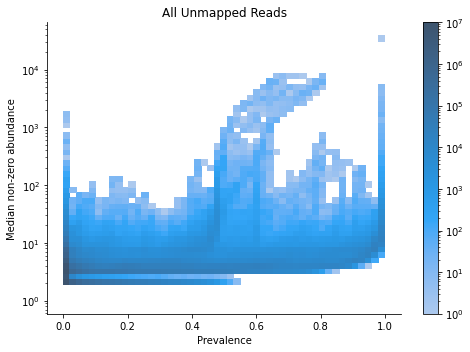

In [8]:
f, ax = plt.subplots(figsize=(7,5))
sns.histplot(y=abunds,x=prevs,log_scale=[False, True],
             norm=LogNorm(), vmin=None, vmax=1e7, bins=[np.linspace(0,1,50), np.linspace(0,np.log10(max(abunds)),50)],ax=ax, cbar=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('All Unmapped Reads')
plt.xlabel('Prevalence')
plt.ylabel('Median non-zero abundance')
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/prev_abundance_all.svg', transparent=True)
plt.show()

## Localized

/home/users/briannac/.local/lib/python3.6/site-packages/seaborn/distributions.py:836: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **artist_kws,


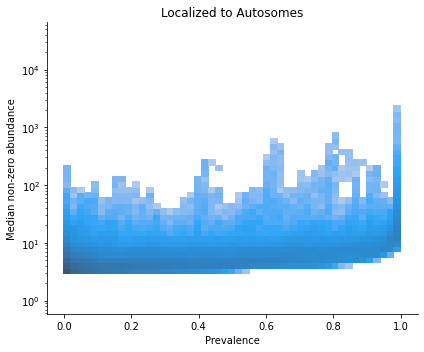

In [9]:
f, ax = plt.subplots(figsize=(6,5))
sns.histplot(data=localized[localized.chrom_pred!='chr24'], x='prev', y='abunds',log_scale=[False, True],
             norm=LogNorm(), vmin=None, vmax=1e7, bins=[np.linspace(0,1,50), np.linspace(0,np.log10(max(abunds)),50)],ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Prevalence')
ax.set_ylabel('Median non-zero abundance')
plt.title('Localized to Autosomes')
plt.xlabel('Prevalence')
plt.ylabel('Median non-zero abundance')
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/prev_abundance_autosomes.svg', transparent=True)
plt.show()

## Y chromsome

/home/users/briannac/.local/lib/python3.6/site-packages/seaborn/distributions.py:836: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **artist_kws,


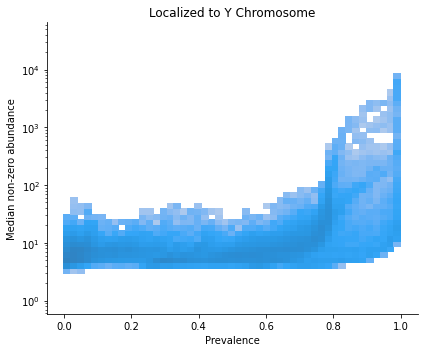

In [10]:
f, ax = plt.subplots(figsize=(6,5))
sns.histplot(data=localized[localized.chrom_pred=='chr24'], x='male_prev', y='abunds',log_scale=[False, True],
             norm=LogNorm(), vmin=None, vmax=1e7, bins=[np.linspace(0,1,50), np.linspace(0,np.log10(max(abunds)),50)],ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Prevalence')
ax.set_ylabel('Median non-zero abundance')
plt.title('Localized to Y Chromosome')
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/prev_abundance_y_chromosome.svg', transparent=True)
plt.show()

# Localized/not vs Prevalence

In [11]:
prevs_localized = prevs[localized.index]
idxs = list(set([i for i in range(len(prevs))]).difference(localized.index))
prevs_unlocalized = prevs[idxs]

#abunds_localized = abunds[localized.index]
#idxs = list(set([i for i in range(len(abunds))]).difference(set(localized.index)))
#abunds_unlocalized = abunds[idxs]

n_localized_filt = sum((localized.prev>.2) & (localized.prev<.8))
n_unlocalized_filt = sum((prevs_unlocalized>.2) & (prevs_unlocalized<.8))

print(len(localized)/max(localized.index), 'localized')
print(sum(localized['chrom_pred']=='chr24')/len(localized), 'Y chrom')
print(n_localized_filt/(n_localized_filt+n_unlocalized_filt), 'percent localized between .2 and .8')

0.17988586093626158 localized
0.032138386663834825 Y chrom
0.7930137538481298 percent localized between .2 and .8


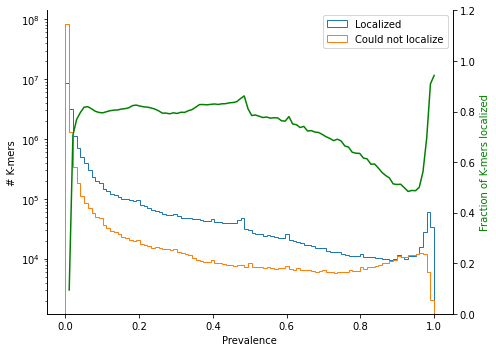

In [12]:
loc_ids = set(localized.index)
f, ax = plt.subplots(figsize=(7,5))
A = ax.hist(prevs_localized, bins=np.linspace(0,1,100), histtype='step', label='Localized')
B = ax.hist(prevs_unlocalized, bins=np.linspace(0,1,100),histtype='step', label='Could not localize')
ax.set_xlabel('Prevalence')
ax.set_ylabel('# K-mers')
ax.set_yscale('log')

ax2=ax.twinx()
ax2.plot(A[1][1:], A[0]/(A[0]+B[0]), color='green')
ax2.set_ylabel('Fraction of K-mers localized', color='green')
ax2.set_ylim(0,1.2)
ax.legend()
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/localized_vs_prev.svg', transparent=True)
plt.show()

## Localization chromosome


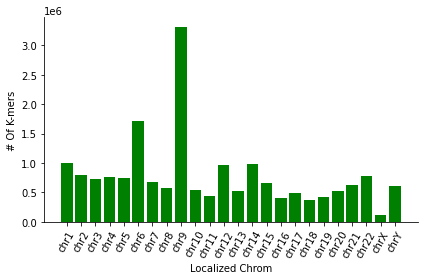

In [13]:
chrom_counter = Counter(localized.chrom_pred)
labels = ['chr'+str(i).replace('23', 'X').replace('24', 'Y') for i in range(1,25)]
f, ax = plt.subplots(figsize=(6,4))
ax.bar(x=labels, height=[chrom_counter[l.replace('Y', '24')] for l in labels], color='green')
plt.xticks(rotation=60)
ax.set_xlabel('Localized Chrom')
ax.set_ylabel('# Of K-mers')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/localized_chromsome.svg', transparent=True)

plt.show()

## Location vs Localization w/Gaps 

In [56]:
localized_old = copy.deepcopy(localized)
localized = localized[(localized.prev>.2) & (localized.prev<.8)]

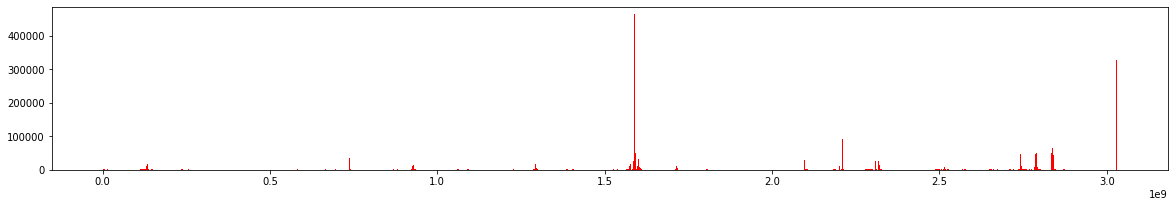

In [57]:
f, ax = plt.subplots(figsize=(20,3))
linear_locs = [loci_linear_idx(int(chrom_pred.replace('chr', '').replace('X', '23')), round((start_pred+end_pred)/2)) for chrom_pred, start_pred, end_pred in zip(
    localized.chrom_pred, localized.start_pred, localized.end_pred)]
nbins = plt.hist(linear_locs, bins=1000, color='r')
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'length', 'location', 7, 8]
gaps_df = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
gaps_df = gaps_df[(gaps_df.type=='N') | (gaps_df.type=='U')]
gaps_df.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df.chrom]

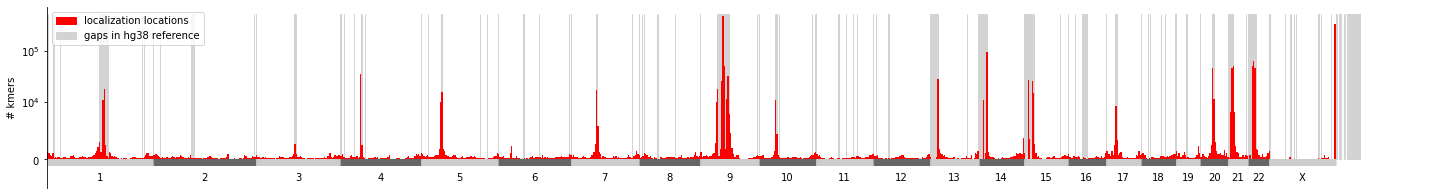

In [100]:
f, ax = plt.subplots(figsize=(20,3))
if True:
    for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
        r = Rectangle(xy=(loci_linear_idx(chrom.replace('chr', ''), start), 0),
                      height=1.1*max(nbins[0]), width=stop-start, color='lightgrey', alpha=1)
        ax.add_patch(r)
    
red_patch = mpatches.Patch(color='red')
grey_patch = mpatches.Patch(color='lightgrey')
p = plt.hist(linear_locs, bins=1000, color='r')
plt.legend([red_patch, grey_patch], ['localization locations', 'gaps in hg38 reference'])
#plt.xlim(0,stop)
plt.yscale('symlog', linthresh=1e4)
plt.ylabel('# kmers')
#plt.xlabel('genome position')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xlim(-.001,)

# PUT IN CHROMSOME STUFF
for i in range(23):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    plt.text(x=np.mean(starts_chrom[i:i+2]), y=-3800, s=chrom, fontsize=10, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts_chrom[i], xmax=starts_chrom[i+1], y=-500, color=color, linestyle='-', linewidth=7)

plt.xticks([])
plt.tight_layout()
ax.set_ylim(-5000,)
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/localized_loci_gaps.svg', transparent=True)
plt.show()

In [141]:
np.round(1111.434, -2)-

1100.0

1


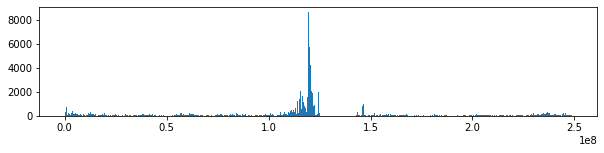

[((120000000, 149000000), 7981), ((121000000, 149000000), 3051), ((120000000, 146000000), 1844), ((120000000, 144000000), 1363), ((116000000, 149000000), 1162), ((117000000, 149000000), 1027), ((119000000, 149000000), 1024), ((125000000, 125000000), 1005), ((118000000, 149000000), 883), ((122000000, 149000000), 724), ((120000000, 125000000), 633), ((121000000, 125000000), 622), ((115000000, 149000000), 585), ((121000000, 144000000), 560), ((120000000, 148000000), 554), ((125000000, 149000000), 501), ((121000000, 146000000), 477), ((122000000, 125000000), 471), ((1000000, 1000000), 464), ((146000000, 149000000), 413)]
2


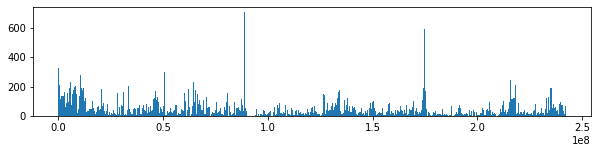

[((175000000, 176000000), 506), ((89000000, 89000000), 460), ((175000000, 177000000), 186), ((7000000, 8000000), 184), ((174000000, 176000000), 179), ((8000000, 8000000), 165), ((127000000, 128000000), 164), ((216000000, 217000000), 157), ((11000000, 12000000), 156), ((218000000, 220000000), 146), ((10000000, 11000000), 146), ((21000000, 23000000), 141), ((2000000, 3000000), 129), ((65000000, 66000000), 117), ((5000000, 5000000), 115), ((5000000, 6000000), 114), ((1000000, 2000000), 111), ((218000000, 219000000), 107), ((34000000, 34000000), 107), ((235000000, 235000000), 106)]
3


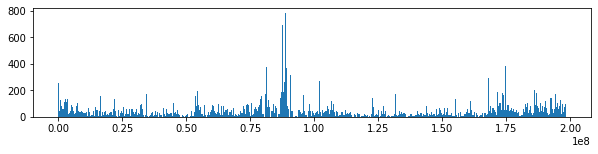

[((88000000, 98000000), 548), ((175000000, 175000000), 293), ((168000000, 169000000), 217), ((102000000, 104000000), 200), ((87000000, 98000000), 194), ((88000000, 96000000), 188), ((89000000, 98000000), 182), ((88000000, 99000000), 176), ((174000000, 175000000), 167), ((0, 1000000), 162), ((54000000, 55000000), 152), ((87000000, 96000000), 151), ((198000000, 198000000), 150), ((88000000, 95000000), 139), ((197000000, 198000000), 138), ((183000000, 184000000), 135), ((187000000, 187000000), 124), ((194000000, 194000000), 118), ((79000000, 84000000), 113), ((186000000, 187000000), 112)]
4


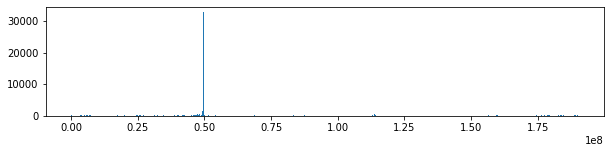

[((49000000, 50000000), 14635), ((50000000, 50000000), 14196), ((49000000, 49000000), 4935), ((179000000, 180000000), 381), ((47000000, 53000000), 376), ((48000000, 53000000), 340), ((48000000, 54000000), 266), ((49000000, 52000000), 251), ((160000000, 160000000), 241), ((49000000, 54000000), 241), ((114000000, 116000000), 236), ((114000000, 115000000), 222), ((6000000, 7000000), 218), ((6000000, 6000000), 211), ((47000000, 54000000), 206), ((184000000, 184000000), 193), ((189000000, 190000000), 182), ((183000000, 184000000), 179), ((49000000, 53000000), 167), ((184000000, 185000000), 152)]
5


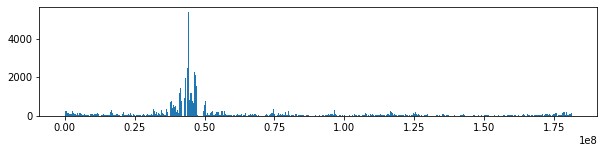

[((44000000, 51000000), 1959), ((44000000, 53000000), 1902), ((44000000, 52000000), 1863), ((47000000, 50000000), 1668), ((46000000, 50000000), 1138), ((47000000, 47000000), 963), ((45000000, 51000000), 901), ((50000000, 50000000), 826), ((46000000, 51000000), 818), ((43000000, 53000000), 789), ((45000000, 53000000), 780), ((45000000, 52000000), 772), ((43000000, 52000000), 765), ((46000000, 52000000), 679), ((43000000, 51000000), 677), ((41000000, 51000000), 601), ((41000000, 53000000), 575), ((46000000, 53000000), 564), ((41000000, 52000000), 490), ((44000000, 54000000), 392)]
6


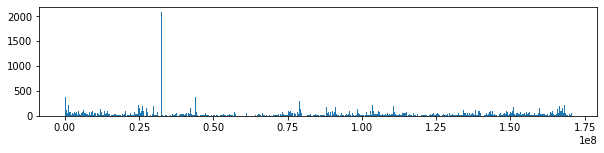

[((33000000, 33000000), 1835), ((26000000, 30000000), 250), ((0, 0), 224), ((167000000, 168000000), 217), ((104000000, 105000000), 212), ((44000000, 44000000), 184), ((25000000, 30000000), 175), ((1000000, 1000000), 165), ((160000000, 161000000), 165), ((168000000, 169000000), 148), ((151000000, 151000000), 144), ((0, 1000000), 136), ((12000000, 13000000), 122), ((14000000, 15000000), 121), ((166000000, 168000000), 120), ((150000000, 151000000), 107), ((168000000, 168000000), 105), ((79000000, 79000000), 99), ((44000000, 45000000), 98), ((42000000, 44000000), 96)]
7


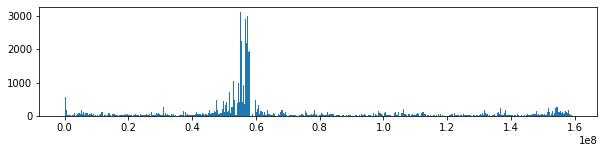

[((57000000, 68000000), 1838), ((57000000, 64000000), 1614), ((57000000, 67000000), 1524), ((55000000, 68000000), 1042), ((58000000, 64000000), 831), ((58000000, 62000000), 804), ((56000000, 68000000), 796), ((56000000, 67000000), 782), ((57000000, 69000000), 768), ((55000000, 67000000), 739), ((57000000, 66000000), 732), ((55000000, 64000000), 705), ((58000000, 63000000), 640), ((55000000, 69000000), 537), ((55000000, 66000000), 485), ((57000000, 63000000), 485), ((57000000, 65000000), 458), ((58000000, 67000000), 440), ((58000000, 68000000), 436), ((56000000, 69000000), 379)]
8


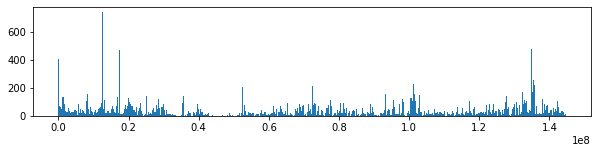

[((13000000, 13000000), 504), ((135000000, 137000000), 328), ((18000000, 18000000), 279), ((135000000, 136000000), 250), ((136000000, 137000000), 217), ((52000000, 54000000), 185), ((0, 1000000), 178), ((20000000, 21000000), 171), ((133000000, 134000000), 151), ((136000000, 136000000), 150), ((1000000, 2000000), 139), ((132000000, 133000000), 136), ((36000000, 37000000), 129), ((101000000, 101000000), 125), ((12000000, 12000000), 123), ((101000000, 102000000), 119), ((0, 2000000), 112), ((101000000, 103000000), 109), ((17000000, 18000000), 109), ((30000000, 31000000), 108)]
9


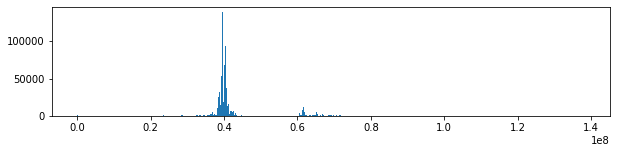

[((40000000, 67000000), 62375), ((40000000, 68000000), 59776), ((40000000, 69000000), 49058), ((41000000, 68000000), 45123), ((41000000, 67000000), 42377), ((39000000, 67000000), 30061), ((41000000, 69000000), 27301), ((39000000, 68000000), 26441), ((40000000, 66000000), 22833), ((39000000, 69000000), 20742), ((39000000, 66000000), 15111), ((40000000, 65000000), 9145), ((41000000, 66000000), 8026), ((39000000, 65000000), 7032), ((41000000, 65000000), 5922), ((41000000, 41000000), 5437), ((62000000, 69000000), 5263), ((62000000, 68000000), 5159), ((40000000, 71000000), 4771), ((40000000, 64000000), 4751)]
10


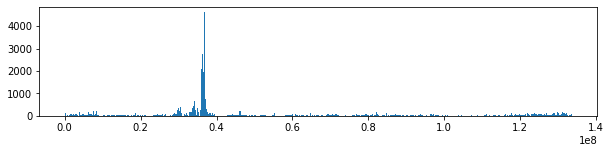

[((37000000, 43000000), 2629), ((36000000, 43000000), 1917), ((36000000, 44000000), 1800), ((37000000, 44000000), 1322), ((36000000, 46000000), 882), ((37000000, 46000000), 774), ((37000000, 45000000), 772), ((36000000, 45000000), 440), ((37000000, 47000000), 339), ((36000000, 47000000), 332), ((34000000, 43000000), 293), ((8000000, 8000000), 244), ((131000000, 132000000), 227), ((36000000, 37000000), 209), ((34000000, 46000000), 191), ((34000000, 36000000), 191), ((34000000, 44000000), 177), ((37000000, 48000000), 169), ((36000000, 48000000), 168), ((35000000, 43000000), 166)]
11


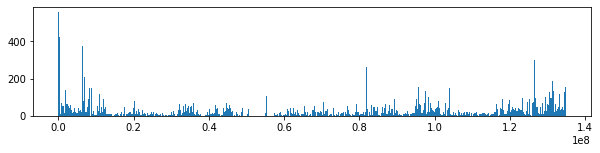

[((6000000, 7000000), 366), ((0, 0), 342), ((0, 1000000), 262), ((7000000, 7000000), 254), ((127000000, 127000000), 247), ((0, 2000000), 242), ((135000000, 135000000), 220), ((131000000, 131000000), 179), ((131000000, 132000000), 176), ((134000000, 135000000), 149), ((82000000, 84000000), 145), ((130000000, 131000000), 135), ((104000000, 104000000), 132), ((9000000, 10000000), 125), ((120000000, 121000000), 121), ((42000000, 44000000), 116), ((2000000, 3000000), 112), ((8000000, 10000000), 110), ((82000000, 83000000), 109), ((2000000, 2000000), 106)]
12


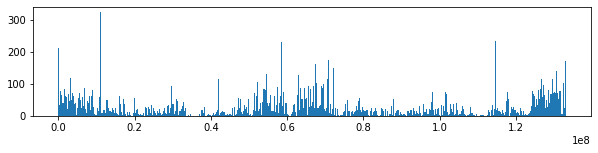

[((11000000, 11000000), 284), ((115000000, 115000000), 214), ((133000000, 133000000), 211), ((58000000, 62000000), 192), ((127000000, 127000000), 167), ((71000000, 71000000), 148), ((129000000, 130000000), 135), ((1000000, 2000000), 131), ((130000000, 131000000), 129), ((132000000, 133000000), 128), ((130000000, 130000000), 127), ((127000000, 128000000), 122), ((126000000, 127000000), 121), ((9000000, 10000000), 120), ((131000000, 133000000), 108), ((4000000, 4000000), 106), ((131000000, 131000000), 104), ((125000000, 125000000), 103), ((0, 0), 103), ((3000000, 4000000), 103)]
13


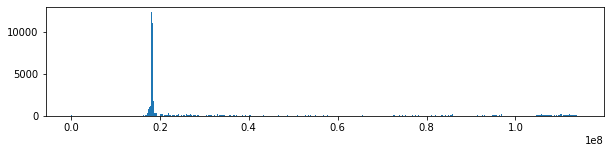

[((18000000, 19000000), 12606), ((18000000, 18000000), 8177), ((18000000, 20000000), 2051), ((19000000, 19000000), 1508), ((18000000, 22000000), 1299), ((18000000, 21000000), 1165), ((17000000, 18000000), 567), ((19000000, 20000000), 493), ((19000000, 22000000), 425), ((17000000, 17000000), 411), ((113000000, 114000000), 396), ((21000000, 22000000), 372), ((22000000, 22000000), 335), ((19000000, 21000000), 303), ((97000000, 98000000), 282), ((26000000, 27000000), 276), ((112000000, 113000000), 253), ((24000000, 25000000), 216), ((96000000, 98000000), 201), ((106000000, 107000000), 189)]
14


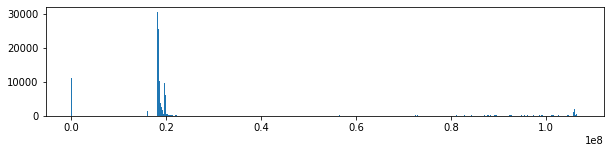

[((18000000, 20000000), 39547), ((20000000, 20000000), 14351), ((19000000, 20000000), 13247), ((18000000, 19000000), 12990), ((0, 20000000), 6905), ((19000000, 19000000), 4640), ((106000000, 106000000), 3534), ((0, 19000000), 2757), ((20000000, 21000000), 2235), ((18000000, 21000000), 2021), ((19000000, 21000000), 1306), ((16000000, 20000000), 876), ((0, 18000000), 741), ((18000000, 18000000), 515), ((0, 21000000), 490), ((88000000, 89000000), 430), ((106000000, 107000000), 428), ((21000000, 21000000), 393), ((16000000, 19000000), 377), ((21000000, 22000000), 321)]
15


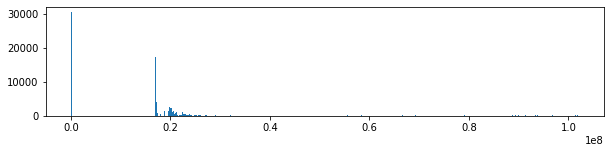

[((0, 20000000), 17564), ((17000000, 20000000), 13102), ((0, 22000000), 4455), ((0, 21000000), 4206), ((17000000, 21000000), 3097), ((17000000, 22000000), 3073), ((0, 23000000), 2842), ((20000000, 20000000), 2792), ((17000000, 23000000), 2319), ((20000000, 21000000), 2196), ((20000000, 22000000), 2097), ((20000000, 23000000), 1684), ((21000000, 21000000), 1430), ((21000000, 22000000), 1396), ((22000000, 22000000), 1100), ((23000000, 23000000), 944), ((19000000, 20000000), 906), ((21000000, 23000000), 825), ((22000000, 23000000), 694), ((23000000, 24000000), 574)]
16


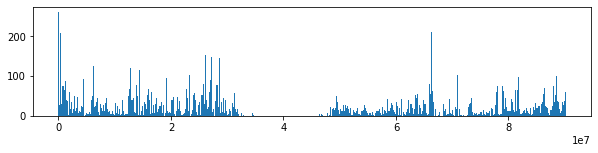

[((0, 1000000), 219), ((26000000, 27000000), 171), ((66000000, 69000000), 160), ((90000000, 90000000), 159), ((6000000, 6000000), 137), ((88000000, 90000000), 135), ((14000000, 16000000), 127), ((0, 0), 123), ((78000000, 79000000), 116), ((89000000, 90000000), 114), ((27000000, 27000000), 110), ((23000000, 24000000), 109), ((82000000, 82000000), 103), ((86000000, 87000000), 92), ((4000000, 4000000), 91), ((13000000, 14000000), 87), ((13000000, 13000000), 84), ((1000000, 2000000), 83), ((15000000, 16000000), 83), ((88000000, 88000000), 83)]
17


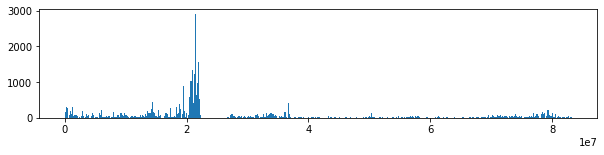

[((21000000, 27000000), 2548), ((21000000, 28000000), 2536), ((22000000, 22000000), 1598), ((22000000, 28000000), 612), ((21000000, 29000000), 570), ((21000000, 22000000), 535), ((14000000, 15000000), 461), ((79000000, 79000000), 453), ((22000000, 27000000), 388), ((0, 1000000), 370), ((14000000, 14000000), 344), ((20000000, 27000000), 337), ((21000000, 31000000), 332), ((21000000, 30000000), 310), ((21000000, 33000000), 306), ((37000000, 37000000), 290), ((20000000, 28000000), 285), ((1000000, 1000000), 277), ((21000000, 32000000), 254), ((22000000, 33000000), 243)]
18


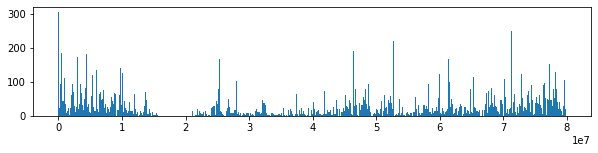

[((0, 1000000), 234), ((4000000, 4000000), 216), ((10000000, 10000000), 215), ((77000000, 78000000), 195), ((3000000, 4000000), 177), ((78000000, 78000000), 154), ((71000000, 71000000), 149), ((9000000, 10000000), 149), ((1000000, 1000000), 149), ((61000000, 62000000), 140), ((78000000, 79000000), 140), ((4000000, 5000000), 140), ((25000000, 25000000), 134), ((76000000, 77000000), 127), ((80000000, 80000000), 126), ((78000000, 80000000), 126), ((53000000, 53000000), 123), ((7000000, 7000000), 120), ((1000000, 2000000), 116), ((7000000, 8000000), 115)]
19


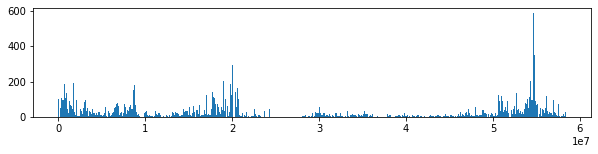

[((55000000, 55000000), 825), ((54000000, 55000000), 375), ((20000000, 22000000), 357), ((1000000, 1000000), 349), ((55000000, 56000000), 290), ((9000000, 9000000), 269), ((1000000, 2000000), 263), ((51000000, 51000000), 261), ((54000000, 54000000), 220), ((3000000, 3000000), 207), ((19000000, 22000000), 206), ((2000000, 2000000), 201), ((18000000, 18000000), 168), ((0, 1000000), 168), ((2000000, 3000000), 165), ((8000000, 9000000), 154), ((56000000, 57000000), 145), ((52000000, 53000000), 143), ((53000000, 53000000), 139), ((20000000, 23000000), 134)]
20


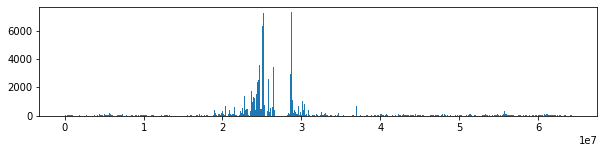

[((25000000, 32000000), 9310), ((25000000, 33000000), 8167), ((29000000, 30000000), 5822), ((24000000, 32000000), 2901), ((26000000, 32000000), 2764), ((24000000, 33000000), 2371), ((29000000, 29000000), 2350), ((29000000, 32000000), 1689), ((25000000, 37000000), 1598), ((26000000, 33000000), 1512), ((26000000, 31000000), 1241), ((25000000, 31000000), 1117), ((30000000, 30000000), 1097), ((23000000, 32000000), 1015), ((29000000, 33000000), 991), ((26000000, 30000000), 922), ((25000000, 35000000), 804), ((29000000, 31000000), 792), ((23000000, 33000000), 715), ((24000000, 37000000), 592)]
21


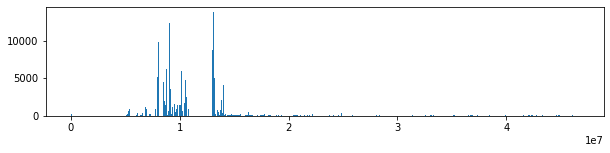

[((9000000, 9000000), 22386), ((13000000, 14000000), 20680), ((8000000, 9000000), 6549), ((14000000, 14000000), 6330), ((8000000, 8000000), 4582), ((10000000, 10000000), 4396), ((10000000, 14000000), 3522), ((13000000, 13000000), 3237), ((10000000, 13000000), 3218), ((9000000, 10000000), 3181), ((11000000, 13000000), 2984), ((9000000, 14000000), 2886), ((10000000, 11000000), 2379), ((11000000, 14000000), 2351), ((13000000, 15000000), 2195), ((8000000, 14000000), 1890), ((9000000, 13000000), 1513), ((14000000, 15000000), 1231), ((13000000, 16000000), 1135), ((11000000, 11000000), 894)]
22


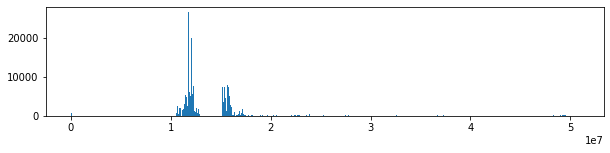

[((12000000, 12000000), 32111), ((12000000, 17000000), 28058), ((16000000, 17000000), 20764), ((15000000, 17000000), 12616), ((12000000, 16000000), 11591), ((11000000, 11000000), 8195), ((16000000, 16000000), 6035), ((15000000, 16000000), 5802), ((11000000, 12000000), 5767), ((17000000, 17000000), 3917), ((15000000, 15000000), 3727), ((11000000, 17000000), 3414), ((13000000, 13000000), 3161), ((11000000, 16000000), 2039), ((12000000, 15000000), 2025), ((12000000, 13000000), 1402), ((11000000, 15000000), 1309), ((17000000, 18000000), 1285), ((12000000, 18000000), 1076), ((13000000, 15000000), 971)]
23


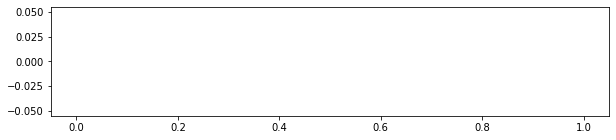

[]


In [172]:
for chrom in range(1,24):
    print(chrom)
    plt.figure(figsize=(10,2))
    plt.hist(np.round(localized[localized.chrom_pred==('chr%i' % chrom)].start_pred), bins=500)
    plt.show()
    print(Counter([(i,j) for i,j in zip(np.round(localized[localized.chrom_pred==('chr%i' % chrom)].start_pred,-6),
                                       np.round(localized[localized.chrom_pred==('chr%i' % chrom)].end_pred,-6))]).most_common(20))
    
    
    

## Prevalence vs Location 

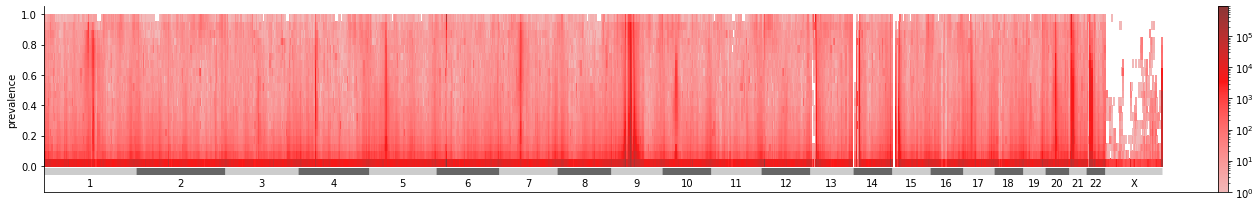

In [17]:
f,ax = plt.subplots(figsize=(20,3))
linear_locs = [loci_linear_idx(int(chrom_pred.replace('chr', '').replace('X', '23')), round((start_pred+end_pred)/2)) for chrom_pred, start_pred, end_pred in zip(
    localized_old.chrom_pred, localized_old.start_pred, localized_old.end_pred)]
p = sns.histplot(x=linear_locs, y=localized_old.prev, ax=ax, norm=LogNorm(), vmin=None, vmax=None, bins=[1000,20], cbar=True, color='red',cbar_kws={"pad": 0.00})

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-.001,)
#ax.set_xlabel('loci')
ax.set_ylabel('prevalence')


# PUT IN CHROMSOME STUFF
for i in range(23):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    plt.text(x=np.mean(starts_chrom[i:i+2]), y=-.13, s=chrom, fontsize=10, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts_chrom[i], xmax=starts_chrom[i+1], y=-.03, color=color, linestyle='-', linewidth=7)

plt.xticks([])
plt.tight_layout()
ax.set_ylim(-.17,)
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/localized_loci_prevs.svg', transparent=True)
plt.show()


# Region Length

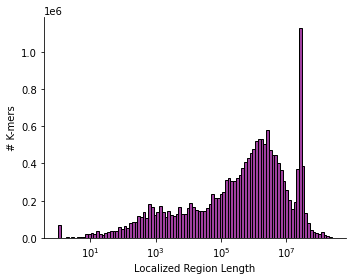

762052.0


In [18]:
f,ax = plt.subplots(figsize=(5,4))
sns.histplot(localized_old[localized_old.chrom_pred!='chr24'].end_pred-localized_old[localized_old.chrom_pred!='chr24'].start_pred, log_scale=True, bins=100, color='purple', ax=ax)
ax.set_xlabel('Localized Region Length')
ax.set_ylabel('# K-mers')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/localized_region_length.svg', transparent=True)
plt.show()
print(np.median(localized_old[localized_old.chrom_pred!='chr24'].end_pred-localized_old[localized_old.chrom_pred!='chr24'].start_pred))

In [60]:
gaps_dict = {i:[] for i in range(1,25)}
for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
    gaps_dict[int(chrom.replace('chr', ''))] = gaps_dict[int(chrom.replace('chr', ''))] + [(start, stop)]

In [80]:
count = 0
middle_in_gap_count = 0
localized_sample = localized.sample(frac=.1, replace=False)
for chrom_pred, start_pred, end_pred in zip(localized_sample.chrom_pred, localized_sample.start_pred, localized_sample.end_pred):
    for i,j in gaps_dict[int(chrom_pred.replace('chr', '').replace('X', '23'))]:
        if (start_pred<i) &  (end_pred>j):
            count = count + 1
            break
    middle = (start_pred+end_pred)/2
    for i,j in gaps_dict[int(chrom_pred.replace('chr', '').replace('X', '23'))]:
        if (middle>i) &  (middle<j):
            middle_in_gap_count = middle_in_gap_count + 1
            break
 #       if (start_pred>i) & (start_pred<j):
 #           count = count+1
 #           break
 ##       if (end_pred>i) & (end_pred<j):
 #           count = count+1
 ##           break
 #       if (i>start_pred) & (i<end_pred):
 #           count = count+1
 #           break
 #       if (j>start_pred) & (j<end_pred):
 #           count = count+1
 #           break

print(count/len(localized_sample), 'to gaps')
print(middle_in_gap_count/len(localized_sample), 'middle in gaps')

print(sum(localized.chrom_pred=='chr24')/len(localized), 'to Y')

0.5687915861772913 to gaps
0.4896583347967765 middle in gaps
0.15941790026917624 to Y


In [90]:
# See if this gap stuff is statistically significant.
np.random.seed(42)
n_iters = 10000
counts = [None for i in range(n_iters)]
middle_in_gap_counts = [None for i in range(n_iters)]

for iter_count in range(n_iters):
    fake_gaps_dict = {}
    for chrom in gaps_dict:
        fake_gaps_dict[chrom] = [(np.random.randint(sizes[chrom-1]-(end-start)),end-start) for start,end in gaps_dict[chrom]]
        fake_gaps_dict[chrom] = [(start, start+length) for start,length in fake_gaps_dict[chrom]]

    count = 0
    middle_in_gap_count = 0

    localized_sample = localized.sample(frac=.001, replace=False)
    for chrom_pred, start_pred, end_pred in zip(localized_sample.chrom_pred, localized_sample.start_pred, localized_sample.end_pred):
        for i,j in fake_gaps_dict[int(chrom_pred.replace('chr', '').replace('X', '23'))]:
            if (start_pred<i) &  (end_pred>j):
                count = count + 1
                break
        middle = (start_pred+end_pred)/2
        for i,j in fake_gaps_dict[int(chrom_pred.replace('chr', '').replace('X', '23'))]:
            if (middle>i) &  (middle<j):
                middle_in_gap_count = middle_in_gap_count + 1
                break
 #           if (end_pred>i) & (end_pred<j):
 ##               count = count+1
  #              break
  #          if (i>start_pred) & (i<end_pred):
  ##              count = count+1
 #               break
 #           if (j>start_pred) & (j<end_pred):
 #               count = count+1
 #               break
 #   print(count/len(localized_sample))
    counts[iter_count] = count/len(localized_sample)
    middle_in_gap_counts[iter_count] = middle_in_gap_count/len(localized_sample)


KeyboardInterrupt: 

In [ ]:
print(np.mean(np.array(counts)<0.5687915861772913))
print(np.mean(np.array(middle_in_gap_counts)<0.4896583347967765))

In [111]:
gaps_df.length = [int(l) for l in gaps_df.length]

In [115]:
gaps_df.sort_values('length', ascending=False)[:20]##[gaps_df.chrom=='chr9']

,chrom,start,stop,idx,type,length,location,7,8
45899,chr24,26673215,56673214,352,N,30000000,heterochromatin,no,na
1870,chr1,125184588,143184587,1871,N,18000000,heterochromatin,no,na
11399,chr15,10001,17000000,2,N,16990000,short_arm,no,na
8971,chr13,10001,16000000,2,N,15990000,short_arm,no,na
10176,chr14,10001,16000000,2,N,15990000,short_arm,no,na
41362,chr9,45518559,60518558,483,N,15000000,heterochromatin,no,na
23987,chr22,10001,10510000,2,N,10500000,short_arm,no,na
13156,chr16,38280683,46280682,586,N,8000000,heterochromatin,no,na
21865,chr21,10001,5010000,2,N,5000000,short_arm,no,na
18881,chr2,90402512,91402511,1035,N,1000000,heterochromatin,no,na


In [194]:
# Getting location of gaps in the hg38, using T2T coordinate system. 
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
gaps_t2t_aligned = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/gaps_hg38_t2t_aligned_starts.bed', header=None)
gaps_t2t_aligned.index = gaps_t2t_aligned[3]
gaps_df = gaps_df.loc[gaps_t2t_aligned.index]
gaps_t2t_aligned = gaps_t2t_aligned[gaps_df['type']=='N']
gaps_t2t_aligned.columns = ['chrom', 'start', 'stop', 'idx']


In [216]:
loci_linear_idx(24,1e8)

3090741381.0

In [222]:
np.argmax(linear_locs)

2856288

In [223]:
localized.iloc[2856288]

chrom_pred          chrX
start_pred     155874946
end_pred       156040895
prev            0.002001
abunds                 3
male_prev     0.00326216
Name: 16020450, dtype: object

In [225]:
np.cumsum(sizes)

array([ 248956422,  491149951,  689445510,  879660065, 1061198324,
       1232004303, 1391350276, 1547391171, 1692529807, 1830924524,
       1966011146, 2099808568, 2233083877, 2347448205, 2454491923,
       2556483112, 2646821457, 2730078898, 2810452183, 2874896350,
       2933513966, 2990741381, 3041559849, 3088269832, 3088286401])